In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.cuda.amp import GradScaler, autocast
import random
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ARSL256Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.class_to_idx = {}

        folders = sorted(os.listdir(root_dir))
        for idx, folder in enumerate(folders):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                self.class_to_idx[folder] = idx
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    self.img_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
transform_basic = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [6]:
data_dir = "dataset"
full_dataset = ARSL256Dataset(root_dir=data_dir, transform=None)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

In [7]:
train_set_aug, val_set_aug = random_split(ARSL256Dataset(root_dir=data_dir, transform=None), [train_size, val_size])

# Assign transforms
train_set.dataset.transform = transform_basic
val_set.dataset.transform = transform_basic

train_set_aug.dataset.transform = transform_aug
val_set_aug.dataset.transform = transform_basic

In [8]:
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

train_loader_aug = DataLoader(train_set_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_set_aug, batch_size=batch_size, shuffle=False)

In [9]:
# Model Definitions
# 1. Base model without BatchNormalization
class VGG16_withoutBN(nn.Module):
    def __init__(self, num_classes=31):
        super(VGG16_withoutBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [10]:
# 2. Model with BatchNormalization
class VGG16_BN(nn.Module):
    def __init__(self, num_classes=31):
        super(VGG16_BN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
def train(model, train_loader, val_loader, epochs=20, lr=0.001, model_name="Model"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"{model_name} - Epoch [{epoch+1}/{epochs}]")

        total_grad_norm = 0

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            grad_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    grad_norm += p.grad.data.norm(2).item()
            total_grad_norm += grad_norm

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

        avg_grad_norm = total_grad_norm / len(train_loader)
        print(f"Average Gradient Norm: {avg_grad_norm:.4f}")

        epoch_acc = 100.0 * correct / total
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        print(f"Train Accuracy: {epoch_acc:.2f}%")

        # Validation
        val_loss, val_correct, val_total = 0.0, 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100.0 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%\n")

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name.lower().replace(" ", "_")}.pth')

        torch.cuda.empty_cache()

    return train_losses, val_losses, train_accs, val_accs

In [12]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs, model_name):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title(f'{model_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def evaluate_model(model, data_loader, class_to_idx):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=list(class_to_idx.keys()), zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


=== Training Base VGG16 without BatchNormalization ===



Base VGG16 - Epoch [1/10]: 100%|██████████| 393/393 [03:10<00:00,  2.06it/s, acc=3.85, loss=3.43]


Average Gradient Norm: 0.8801
Train Accuracy: 3.85%
Validation Accuracy: 3.69%



Base VGG16 - Epoch [2/10]: 100%|██████████| 393/393 [02:41<00:00,  2.43it/s, acc=4.12, loss=3.43]


Average Gradient Norm: 0.8847
Train Accuracy: 4.12%
Validation Accuracy: 3.69%



Base VGG16 - Epoch [3/10]: 100%|██████████| 393/393 [02:38<00:00,  2.47it/s, acc=4.04, loss=3.43]


Average Gradient Norm: 0.8856
Train Accuracy: 4.04%
Validation Accuracy: 3.69%



Base VGG16 - Epoch [4/10]: 100%|██████████| 393/393 [02:40<00:00,  2.45it/s, acc=3.91, loss=3.4] 


Average Gradient Norm: 0.8903
Train Accuracy: 3.91%
Validation Accuracy: 3.95%



Base VGG16 - Epoch [5/10]: 100%|██████████| 393/393 [02:39<00:00,  2.46it/s, acc=3.93, loss=3.46]


Average Gradient Norm: 0.8891
Train Accuracy: 3.93%
Validation Accuracy: 3.69%



Base VGG16 - Epoch [6/10]: 100%|██████████| 393/393 [02:39<00:00,  2.46it/s, acc=3.68, loss=3.44]


Average Gradient Norm: 0.9003
Train Accuracy: 3.68%
Validation Accuracy: 3.95%



Base VGG16 - Epoch [7/10]: 100%|██████████| 393/393 [02:39<00:00,  2.46it/s, acc=3.56, loss=3.44]


Average Gradient Norm: 0.9035
Train Accuracy: 3.56%
Validation Accuracy: 3.69%



Base VGG16 - Epoch [8/10]: 100%|██████████| 393/393 [02:39<00:00,  2.47it/s, acc=3.98, loss=3.43]


Average Gradient Norm: 0.9132
Train Accuracy: 3.98%
Validation Accuracy: 3.69%



Base VGG16 - Epoch [9/10]: 100%|██████████| 393/393 [02:40<00:00,  2.45it/s, acc=4.15, loss=3.43]


Average Gradient Norm: 0.9063
Train Accuracy: 4.15%
Validation Accuracy: 3.69%



Base VGG16 - Epoch [10/10]: 100%|██████████| 393/393 [02:39<00:00,  2.46it/s, acc=3.69, loss=3.39]


Average Gradient Norm: 0.9105
Train Accuracy: 3.69%
Validation Accuracy: 3.69%



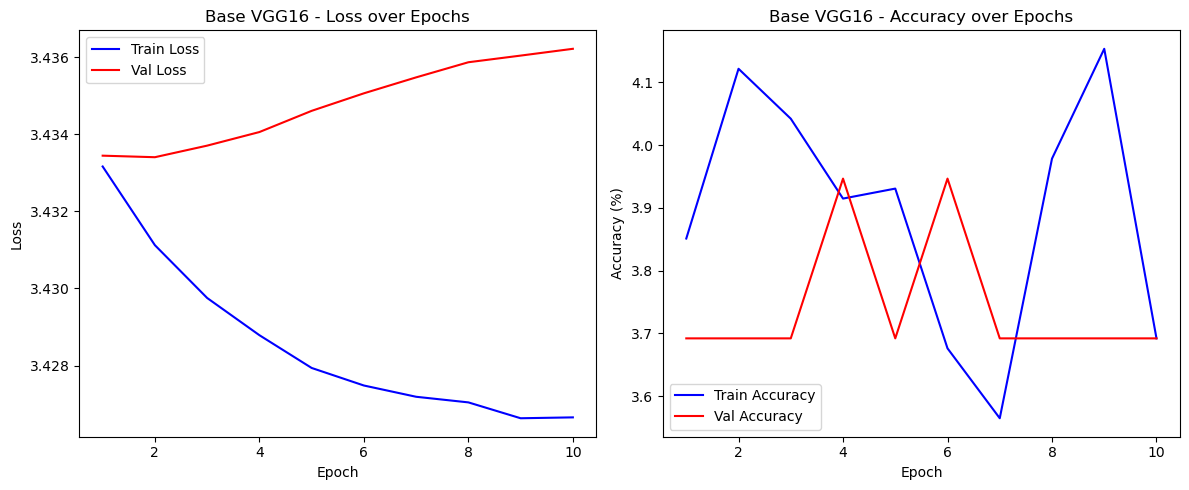

              precision    recall  f1-score   support

         Ain       0.00      0.00      0.00        44
          Al       0.00      0.00      0.00        60
        Alef       0.00      0.00      0.00        39
         Beh       0.04      1.00      0.07        58
         Dad       0.00      0.00      0.00        35
         Dal       0.00      0.00      0.00        56
         Feh       0.00      0.00      0.00        53
       Ghain       0.00      0.00      0.00        50
         Hah       0.00      0.00      0.00        51
         Heh       0.00      0.00      0.00        56
        Jeem       0.00      0.00      0.00        49
         Kaf       0.00      0.00      0.00        47
        Khah       0.00      0.00      0.00        48
         Laa       0.00      0.00      0.00        51
         Lam       0.00      0.00      0.00        41
        Meem       0.00      0.00      0.00        51
        Noon       0.00      0.00      0.00        45
         Qaf       0.00    

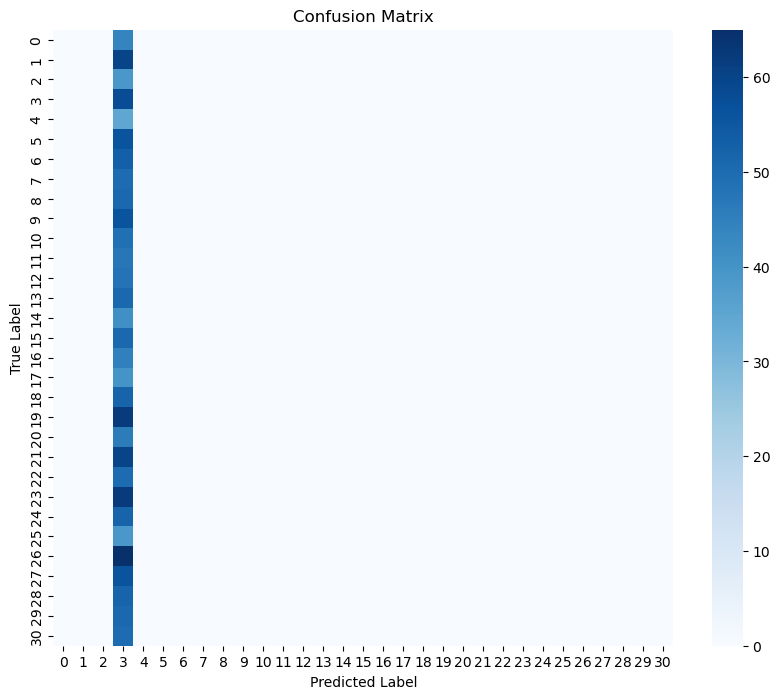

In [14]:
# Training and Evaluation

# Model 1: Base VGG16 without BatchNorm

print("\n=== Training Base VGG16 without BatchNormalization ===\n")
model_no_bn = VGG16_withoutBN(num_classes=31)
train_losses_no_bn, val_losses_no_bn, train_accs_no_bn, val_accs_no_bn = train(
    model_no_bn, train_loader, val_loader, epochs=10, lr=0.001, model_name="Base VGG16")
plot_metrics(train_losses_no_bn, val_losses_no_bn, train_accs_no_bn, val_accs_no_bn, "Base VGG16")
evaluate_model(model_no_bn, val_loader, full_dataset.class_to_idx)


=== Training VGG16 with BatchNormalization ===



VGG16 with BN - Epoch [1/20]: 100%|██████████| 393/393 [02:45<00:00,  2.38it/s, acc=3.85, loss=3.35]


Average Gradient Norm: 49.0934
Train Accuracy: 3.85%
Validation Accuracy: 5.28%



VGG16 with BN - Epoch [2/20]: 100%|██████████| 393/393 [02:47<00:00,  2.35it/s, acc=8.26, loss=2.92]


Average Gradient Norm: 40.4051
Train Accuracy: 8.26%
Validation Accuracy: 14.19%



VGG16 with BN - Epoch [3/20]: 100%|██████████| 393/393 [02:47<00:00,  2.34it/s, acc=25, loss=1.86]  


Average Gradient Norm: 67.6938
Train Accuracy: 24.97%
Validation Accuracy: 20.69%



VGG16 with BN - Epoch [4/20]: 100%|██████████| 393/393 [02:48<00:00,  2.34it/s, acc=44, loss=2.08]   


Average Gradient Norm: 76.4847
Train Accuracy: 44.03%
Validation Accuracy: 43.41%



VGG16 with BN - Epoch [5/20]: 100%|██████████| 393/393 [02:41<00:00,  2.44it/s, acc=59.3, loss=1.17] 


Average Gradient Norm: 74.7896
Train Accuracy: 59.26%
Validation Accuracy: 46.98%



VGG16 with BN - Epoch [6/20]: 100%|██████████| 393/393 [02:38<00:00,  2.48it/s, acc=68.1, loss=0.724]


Average Gradient Norm: 74.2100
Train Accuracy: 68.11%
Validation Accuracy: 63.91%



VGG16 with BN - Epoch [7/20]: 100%|██████████| 393/393 [02:38<00:00,  2.48it/s, acc=76.5, loss=0.526]


Average Gradient Norm: 70.9177
Train Accuracy: 76.46%
Validation Accuracy: 67.54%



VGG16 with BN - Epoch [8/20]: 100%|██████████| 393/393 [02:38<00:00,  2.49it/s, acc=82.9, loss=0.938] 


Average Gradient Norm: 68.0874
Train Accuracy: 82.94%
Validation Accuracy: 69.45%



VGG16 with BN - Epoch [9/20]: 100%|██████████| 393/393 [02:38<00:00,  2.49it/s, acc=85.3, loss=0.516] 


Average Gradient Norm: 67.5667
Train Accuracy: 85.30%
Validation Accuracy: 70.08%



VGG16 with BN - Epoch [10/20]: 100%|██████████| 393/393 [02:37<00:00,  2.49it/s, acc=88.8, loss=0.417] 


Average Gradient Norm: 61.4190
Train Accuracy: 88.80%
Validation Accuracy: 77.15%



VGG16 with BN - Epoch [11/20]: 100%|██████████| 393/393 [02:38<00:00,  2.49it/s, acc=92.1, loss=0.641] 


Average Gradient Norm: 55.5908
Train Accuracy: 92.08%
Validation Accuracy: 72.25%



VGG16 with BN - Epoch [12/20]: 100%|██████████| 393/393 [02:38<00:00,  2.48it/s, acc=93, loss=0.379]   


Average Gradient Norm: 54.4108
Train Accuracy: 92.98%
Validation Accuracy: 80.71%



VGG16 with BN - Epoch [13/20]: 100%|██████████| 393/393 [02:38<00:00,  2.49it/s, acc=94.6, loss=0.308]  


Average Gradient Norm: 47.5210
Train Accuracy: 94.57%
Validation Accuracy: 78.49%



VGG16 with BN - Epoch [14/20]: 100%|██████████| 393/393 [02:38<00:00,  2.49it/s, acc=95.9, loss=0.246]  


Average Gradient Norm: 39.2487
Train Accuracy: 95.94%
Validation Accuracy: 79.31%



VGG16 with BN - Epoch [15/20]: 100%|██████████| 393/393 [02:38<00:00,  2.48it/s, acc=95.8, loss=0.00824]


Average Gradient Norm: 44.3443
Train Accuracy: 95.83%
Validation Accuracy: 78.93%



VGG16 with BN - Epoch [16/20]: 100%|██████████| 393/393 [02:46<00:00,  2.35it/s, acc=96.5, loss=0.172]   


Average Gradient Norm: 39.6715
Train Accuracy: 96.50%
Validation Accuracy: 81.29%



VGG16 with BN - Epoch [17/20]: 100%|██████████| 393/393 [02:42<00:00,  2.42it/s, acc=97.8, loss=0.354]  


Average Gradient Norm: 30.8125
Train Accuracy: 97.77%
Validation Accuracy: 81.86%



VGG16 with BN - Epoch [18/20]: 100%|██████████| 393/393 [02:40<00:00,  2.45it/s, acc=97.6, loss=0.016]   


Average Gradient Norm: 31.6541
Train Accuracy: 97.58%
Validation Accuracy: 82.81%



VGG16 with BN - Epoch [19/20]: 100%|██████████| 393/393 [02:44<00:00,  2.38it/s, acc=97.5, loss=0.0905]  


Average Gradient Norm: 34.2605
Train Accuracy: 97.49%
Validation Accuracy: 81.92%



VGG16 with BN - Epoch [20/20]: 100%|██████████| 393/393 [02:46<00:00,  2.36it/s, acc=97.6, loss=0.0441]  


Average Gradient Norm: 30.8299
Train Accuracy: 97.64%
Validation Accuracy: 82.30%



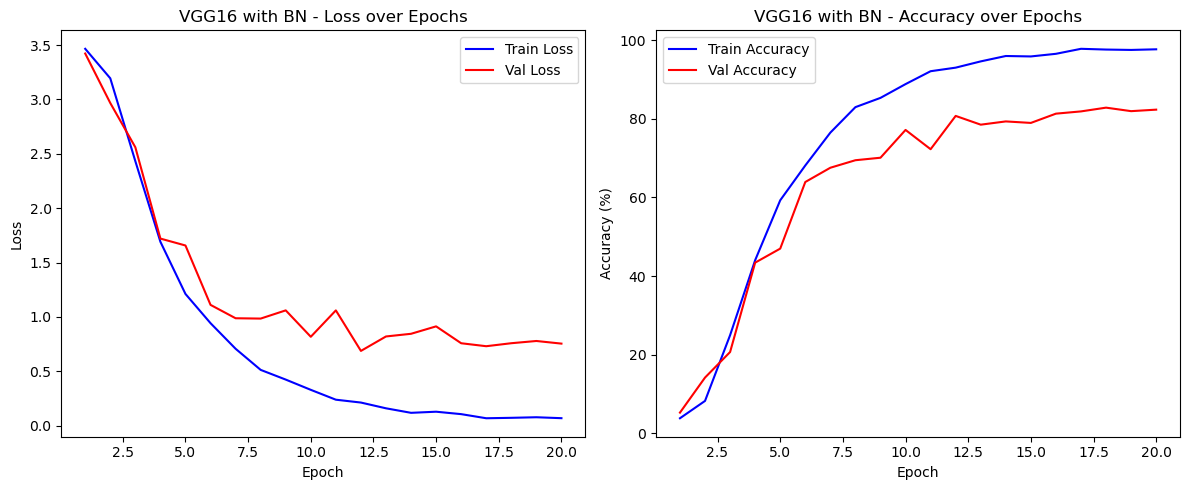

              precision    recall  f1-score   support

         Ain       0.83      0.80      0.81        44
          Al       0.95      0.98      0.97        60
        Alef       0.83      0.90      0.86        39
         Beh       0.79      0.93      0.86        58
         Dad       0.91      0.91      0.91        35
         Dal       0.74      0.70      0.72        56
         Feh       0.57      0.68      0.62        53
       Ghain       0.90      0.72      0.80        50
         Hah       0.84      0.84      0.84        51
         Heh       0.75      0.80      0.78        56
        Jeem       0.79      0.78      0.78        49
         Kaf       0.74      0.83      0.78        47
        Khah       0.88      0.88      0.88        48
         Laa       0.82      0.88      0.85        51
         Lam       0.86      0.88      0.87        41
        Meem       0.84      0.63      0.72        51
        Noon       0.84      0.82      0.83        45
         Qaf       0.49    

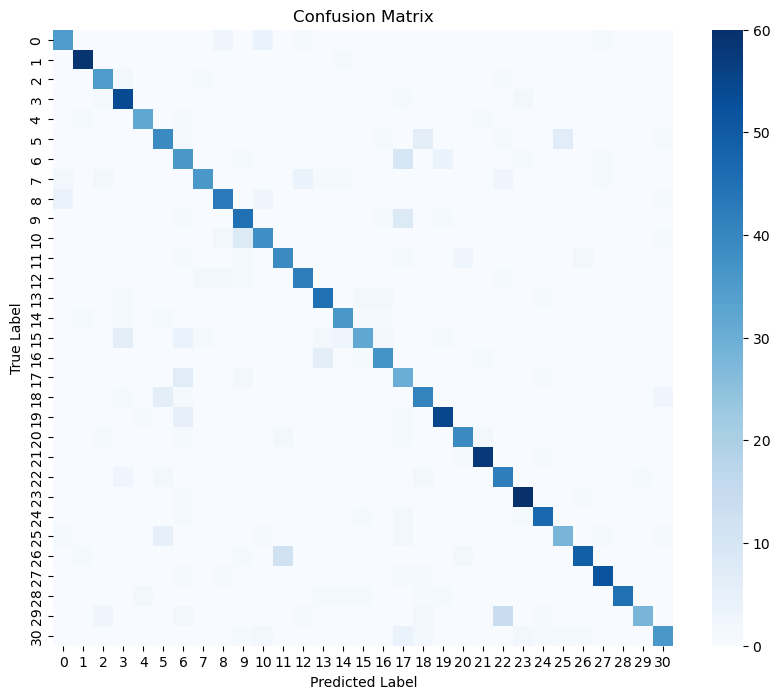

In [15]:
# Model 2: VGG16 with BatchNorm

print("\n=== Training VGG16 with BatchNormalization ===\n")
model_with_bn = VGG16_BN(num_classes=31)
train_losses_with_bn, val_losses_with_bn, train_accs_with_bn, val_accs_with_bn = train(
    model_with_bn, train_loader, val_loader, epochs=20, lr=0.001, model_name="VGG16 with BN")
plot_metrics(train_losses_with_bn, val_losses_with_bn, train_accs_with_bn, val_accs_with_bn, "VGG16 with BN")
evaluate_model(model_with_bn, val_loader, full_dataset.class_to_idx)


=== Training VGG16 with BatchNormalization and Data Augmentation ===



VGG16 with BN+Aug - Epoch [1/20]: 100%|██████████| 393/393 [02:48<00:00,  2.34it/s, acc=3.37, loss=3.59]


Average Gradient Norm: 43.8965
Train Accuracy: 3.37%
Validation Accuracy: 4.65%



VGG16 with BN+Aug - Epoch [2/20]: 100%|██████████| 393/393 [02:48<00:00,  2.34it/s, acc=5.79, loss=2.77]


Average Gradient Norm: 32.2120
Train Accuracy: 5.79%
Validation Accuracy: 9.80%



VGG16 with BN+Aug - Epoch [3/20]: 100%|██████████| 393/393 [02:47<00:00,  2.35it/s, acc=15.1, loss=2.58]


Average Gradient Norm: 54.4495
Train Accuracy: 15.09%
Validation Accuracy: 19.61%



VGG16 with BN+Aug - Epoch [4/20]: 100%|██████████| 393/393 [02:43<00:00,  2.40it/s, acc=34.9, loss=1.7] 


Average Gradient Norm: 74.0377
Train Accuracy: 34.95%
Validation Accuracy: 32.59%



VGG16 with BN+Aug - Epoch [5/20]: 100%|██████████| 393/393 [02:41<00:00,  2.44it/s, acc=54.1, loss=1.56] 


Average Gradient Norm: 76.9847
Train Accuracy: 54.12%
Validation Accuracy: 56.59%



VGG16 with BN+Aug - Epoch [6/20]: 100%|██████████| 393/393 [02:39<00:00,  2.46it/s, acc=65.5, loss=0.537]


Average Gradient Norm: 73.5713
Train Accuracy: 65.47%
Validation Accuracy: 66.65%



VGG16 with BN+Aug - Epoch [7/20]: 100%|██████████| 393/393 [02:42<00:00,  2.42it/s, acc=73.8, loss=1.02] 


Average Gradient Norm: 73.9310
Train Accuracy: 73.79%
Validation Accuracy: 68.68%



VGG16 with BN+Aug - Epoch [8/20]: 100%|██████████| 393/393 [02:40<00:00,  2.45it/s, acc=80.3, loss=0.25] 


Average Gradient Norm: 69.5097
Train Accuracy: 80.28%
Validation Accuracy: 70.66%



VGG16 with BN+Aug - Epoch [9/20]: 100%|██████████| 393/393 [02:41<00:00,  2.44it/s, acc=84.3, loss=0.679] 


Average Gradient Norm: 67.1732
Train Accuracy: 84.28%
Validation Accuracy: 73.58%



VGG16 with BN+Aug - Epoch [10/20]: 100%|██████████| 393/393 [02:38<00:00,  2.47it/s, acc=89.1, loss=0.263] 


Average Gradient Norm: 59.1353
Train Accuracy: 89.15%
Validation Accuracy: 77.34%



VGG16 with BN+Aug - Epoch [11/20]: 100%|██████████| 393/393 [02:38<00:00,  2.48it/s, acc=90.6, loss=0.481] 


Average Gradient Norm: 59.0719
Train Accuracy: 90.64%
Validation Accuracy: 80.39%



VGG16 with BN+Aug - Epoch [12/20]: 100%|██████████| 393/393 [02:38<00:00,  2.47it/s, acc=93.3, loss=0.0552] 


Average Gradient Norm: 52.6378
Train Accuracy: 93.25%
Validation Accuracy: 79.89%



VGG16 with BN+Aug - Epoch [13/20]: 100%|██████████| 393/393 [02:41<00:00,  2.43it/s, acc=94.1, loss=0.0597]


Average Gradient Norm: 50.3129
Train Accuracy: 94.10%
Validation Accuracy: 77.02%



VGG16 with BN+Aug - Epoch [14/20]: 100%|██████████| 393/393 [02:52<00:00,  2.28it/s, acc=96, loss=0.0504]   


Average Gradient Norm: 40.9503
Train Accuracy: 95.97%
Validation Accuracy: 80.20%



VGG16 with BN+Aug - Epoch [15/20]: 100%|██████████| 393/393 [02:44<00:00,  2.39it/s, acc=96.1, loss=0.205]  


Average Gradient Norm: 42.3184
Train Accuracy: 96.12%
Validation Accuracy: 80.20%



VGG16 with BN+Aug - Epoch [16/20]: 100%|██████████| 393/393 [02:39<00:00,  2.46it/s, acc=98.8, loss=0.0462]  


Average Gradient Norm: 19.0261
Train Accuracy: 98.82%
Validation Accuracy: 86.19%



VGG16 with BN+Aug - Epoch [17/20]: 100%|██████████| 393/393 [02:43<00:00,  2.40it/s, acc=99.5, loss=0.00123] 


Average Gradient Norm: 10.0756
Train Accuracy: 99.52%
Validation Accuracy: 87.08%



VGG16 with BN+Aug - Epoch [18/20]: 100%|██████████| 393/393 [02:39<00:00,  2.47it/s, acc=99.8, loss=0.0216]  


Average Gradient Norm: 6.9230
Train Accuracy: 99.79%
Validation Accuracy: 86.95%



VGG16 with BN+Aug - Epoch [19/20]: 100%|██████████| 393/393 [02:39<00:00,  2.47it/s, acc=99.8, loss=0.00154] 


Average Gradient Norm: 5.4104
Train Accuracy: 99.81%
Validation Accuracy: 86.57%



VGG16 with BN+Aug - Epoch [20/20]: 100%|██████████| 393/393 [02:39<00:00,  2.47it/s, acc=99.8, loss=0.00133] 


Average Gradient Norm: 4.6527
Train Accuracy: 99.84%
Validation Accuracy: 87.97%



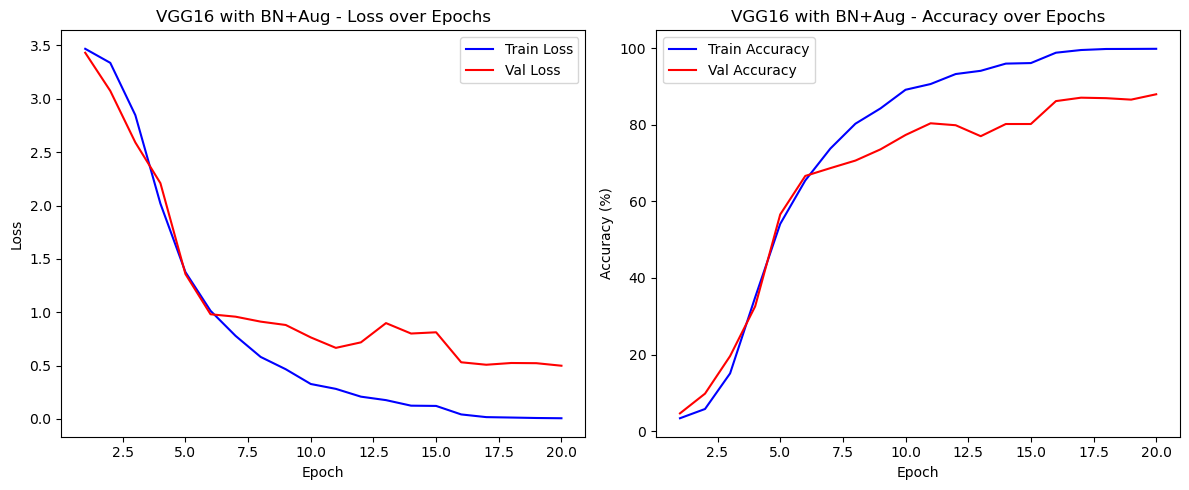

              precision    recall  f1-score   support

         Ain       0.85      0.93      0.89        42
          Al       0.93      0.93      0.93        55
        Alef       0.92      0.85      0.89        41
         Beh       0.85      0.91      0.88        66
         Dad       0.93      0.96      0.94        53
         Dal       0.88      0.86      0.87        50
         Feh       0.78      0.65      0.71        49
       Ghain       0.83      0.90      0.86        48
         Hah       0.86      0.94      0.90        51
         Heh       0.85      0.88      0.87        52
        Jeem       0.89      0.77      0.82        43
         Kaf       0.92      0.83      0.87        58
        Khah       0.91      0.84      0.88        58
         Laa       0.95      0.93      0.94        56
         Lam       0.98      0.94      0.96        52
        Meem       0.80      0.76      0.78        49
        Noon       0.78      0.91      0.84        46
         Qaf       0.80    

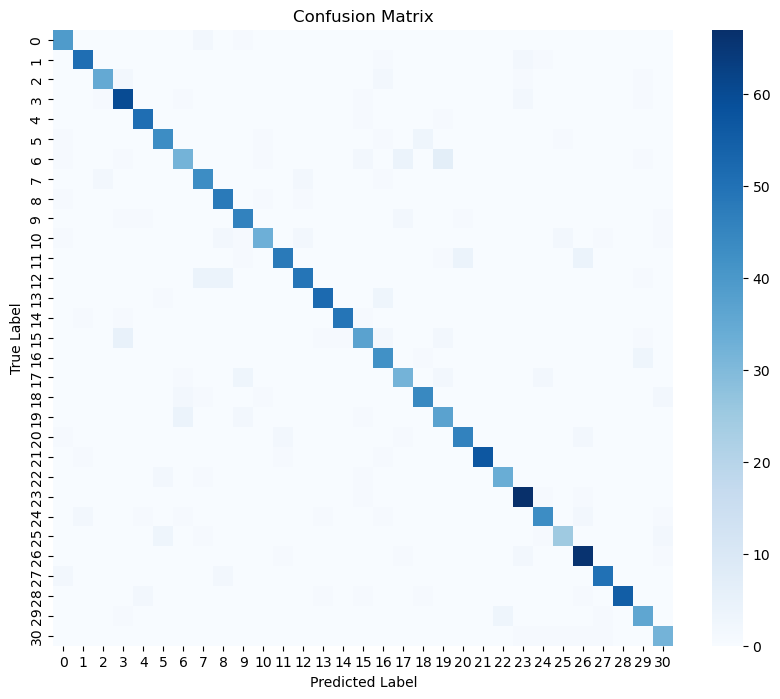

In [16]:
# Model 3: VGG16 with BatchNorm + Augmentation

print("\n=== Training VGG16 with BatchNormalization and Data Augmentation ===\n")
model_with_bn_aug = VGG16_BN(num_classes=31)
train_losses_with_bn_aug, val_losses_with_bn_aug, train_accs_with_bn_aug, val_accs_with_bn_aug = train(
    model_with_bn_aug, train_loader_aug, val_loader_aug, epochs=20, lr=0.001, model_name="VGG16 with BN+Aug")
plot_metrics(train_losses_with_bn_aug, val_losses_with_bn_aug, train_accs_with_bn_aug, val_accs_with_bn_aug, "VGG16 with BN+Aug")
evaluate_model(model_with_bn_aug, val_loader_aug, full_dataset.class_to_idx)

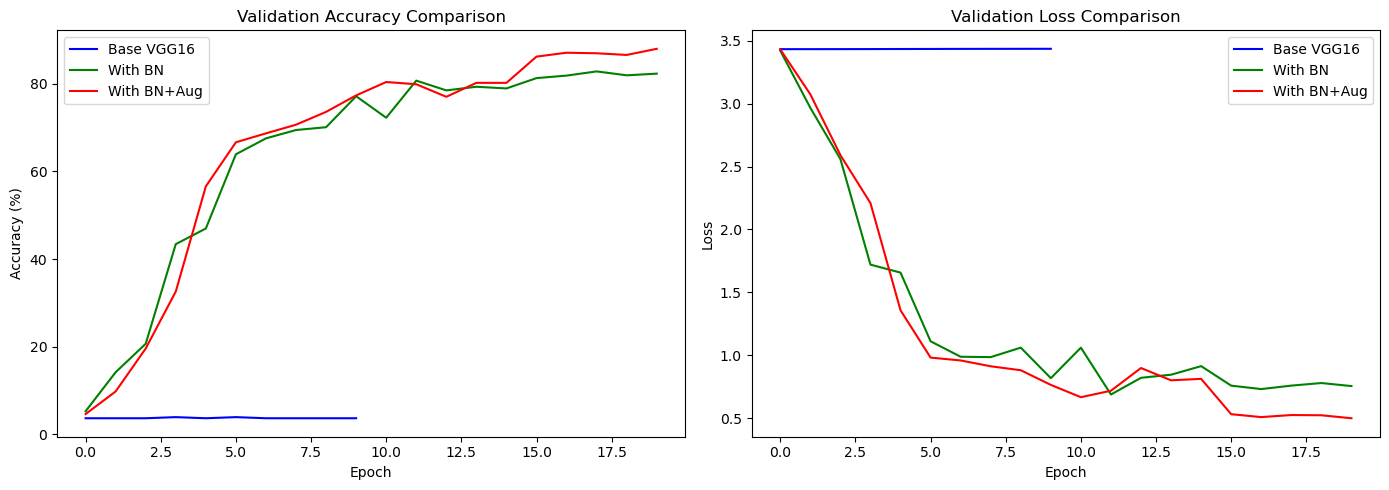

In [17]:
plt.figure(figsize=(14, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(val_accs_no_bn, 'b-', label='Base VGG16')
plt.plot(val_accs_with_bn, 'g-', label='With BN')
plt.plot(val_accs_with_bn_aug, 'r-', label='With BN+Aug')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(val_losses_no_bn, 'b-', label='Base VGG16')
plt.plot(val_losses_with_bn, 'g-', label='With BN')
plt.plot(val_losses_with_bn_aug, 'r-', label='With BN+Aug')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
from tabulate import tabulate

results = [
    ["Model", "Best Train Acc", "Best Val Acc", "Final Val Loss"],
    ["Base VGG16", f"{max(train_accs_no_bn):.2f}%", f"{max(val_accs_no_bn):.2f}%", f"{val_losses_no_bn[-1]:.4f}"],
    ["With BN", f"{max(train_accs_with_bn):.2f}%", f"{max(val_accs_with_bn):.2f}%", f"{val_losses_with_bn[-1]:.4f}"],
    ["With BN+Aug", f"{max(train_accs_with_bn_aug):.2f}%", f"{max(val_accs_with_bn_aug):.2f}%", f"{val_losses_with_bn_aug[-1]:.4f}"]
]

print(tabulate(results, headers="firstrow", tablefmt="grid"))


+-------------+------------------+----------------+------------------+
| Model       | Best Train Acc   | Best Val Acc   |   Final Val Loss |
+=============+==================+================+==================+
| Base VGG16  | 4.15%            | 3.95%          |           3.4362 |
+-------------+------------------+----------------+------------------+
| With BN     | 97.77%           | 82.81%         |           0.7548 |
+-------------+------------------+----------------+------------------+
| With BN+Aug | 99.84%           | 87.97%         |           0.499  |
+-------------+------------------+----------------+------------------+


In [1]:
"""
## Key Findings:


1. **Data Augmentation Impact**:
   - Better generalization (reduced overfitting)
   - Higher validation accuracy than BN-only model
   - Much smaller gap between training and validation metrics
   - More stable validation loss curve

2. **Combined Effect**:
   - Using both BN and augmentation gives the best results
   - BN handles internal covariate shift while augmentation handles input variability
   - Leads to faster convergence and better generalization

## Recommendations:
1. Always use BatchNormalization in deep CNNs
2. Implement appropriate data augmentation for your domain
3. Monitor both training and validation metrics to assess generalization
4. The combination of BN+Augmentation allows for higher learning rates and more training epochs
"""

'\n## Key Findings:\n\n\n1. **Data Augmentation Impact**:\n   - Better generalization (reduced overfitting)\n   - Higher validation accuracy than BN-only model\n   - Much smaller gap between training and validation metrics\n   - More stable validation loss curve\n\n2. **Combined Effect**:\n   - Using both BN and augmentation gives the best results\n   - BN handles internal covariate shift while augmentation handles input variability\n   - Leads to faster convergence and better generalization\n\n## Recommendations:\n1. Always use BatchNormalization in deep CNNs\n2. Implement appropriate data augmentation for your domain\n3. Monitor both training and validation metrics to assess generalization\n4. The combination of BN+Augmentation allows for higher learning rates and more training epochs\n'